<a href="https://colab.research.google.com/github/Nikhilkumar908/Leaf_Disease_Detection/blob/main/Project_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
# Check if TensorFlow is using GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU is not available. Switching to CPU.")

Default GPU Device: /device:GPU:0


In [2]:
print(tf.__version__)

2.15.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pandas as pd
import google.colab.drive as drive
import os, requests, cv2, random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [4]:
import os
root_dir = "/content/drive/My Drive/"
project_folder = "Colab Notebooks/Project_folder/"
def create_and_set_working_directory(project_folder):
 if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + 'did not existed and was created.')
os.chdir(root_dir + project_folder)
!touch 'new_file_test.txt'
print('working directory' + root_dir + project_folder + \
        "empty text file created.")

create_and_set_working_directory(project_folder)

working directory/content/drive/My Drive/Colab Notebooks/Project_folder/empty text file created.


In [5]:
Image_Size = 256
Batch_Size = 32
Channels = 3
Epochs =30

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [7]:
image_directory = '/content/drive/My Drive/Colab Notebooks/Project_folder/PlantVillage'
if not os.path.exists(image_directory):
    raise ValueError(f"Image directory not found: {image_directory}")

In [8]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
image_directory,
batch_size=Batch_Size,
image_size=(Image_Size,Image_Size),
shuffle=True)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                               shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                validation_split=0.3)

test_datagen = ImageDataGenerator(rescale=1/255.0,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)

In [11]:
train_gen = train_datagen.flow_from_directory(
                                image_directory,
                                target_size=(224, 224),
                                batch_size=32,
                                shuffle=True,
                                class_mode='categorical',
                                subset='training')

Found 1507 images belonging to 3 classes.


In [12]:
val_gen = train_datagen.flow_from_directory(
                                image_directory,
                                target_size=(224,224),
                                batch_size=32,
                                shuffle=True,
                                class_mode='categorical',
                                subset='validation')

Found 645 images belonging to 3 classes.


In [13]:
test_gen = test_datagen.flow_from_directory(
        image_directory,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle = False)

Found 2152 images belonging to 3 classes.


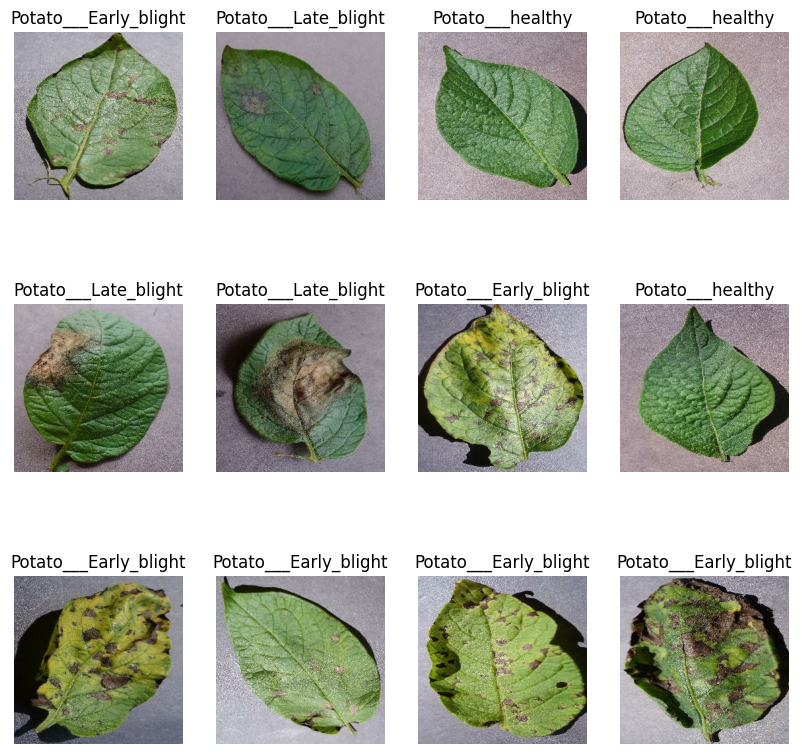

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [15]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [16]:
train_ds = dataset.take(54)
len(train_ds)

54

In [17]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [18]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [19]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [20]:
val_ds = test_ds.skip(6)
len(val_ds)

8

In [21]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
        assert (train_split + test_split + val_split) == 1

        ds_size=len(ds)
        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
        train_size=int(train_split*ds_size)
        val_size=int(val_split*ds_size)
        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        return train_ds, val_ds, ds.skip(train_size).skip(val_size)

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

54

In [24]:
len(val_ds)

6

In [25]:
len(test_ds)

8

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.57254905 0.5647059  0.61960787]
  [0.6        0.5921569  0.64705884]
  [0.62352943 0.6156863  0.67058825]
  ...
  [0.47058824 0.4392157  0.49803922]
  [0.43137255 0.4        0.45882353]
  [0.48235294 0.4509804  0.50980395]]

 [[0.70980394 0.7019608  0.75686276]
  [0.65882355 0.6509804  0.7058824 ]
  [0.62352943 0.6156863  0.67058825]
  ...
  [0.39215687 0.36078432 0.41960785]
  [0.4        0.36862746 0.42745098]
  [0.46666667 0.43529412 0.49411765]]

 [[0.6862745  0.6784314  0.73333335]
  [0.6666667  0.65882355 0.7137255 ]
  [0.68235296 0.6745098  0.7294118 ]
  ...
  [0.40392157 0.37254903 0.43137255]
  [0.44313726 0.4117647  0.47058824]
  [0.45490196 0.42352942 0.48235294]]

 ...

 [[0.5294118  0.49803922 0.54901963]
  [0.44705883 0.41568628 0.46666667]
  [0.49019608 0.45882353 0.50980395]
  ...
  [0.41960785 0.37254903 0.41960785]
  [0.40784314 0.36078432 0.40784314]
  [0.39607844 0.34901962 0.39607844]]

 [[0.5686275  0.5372549  0.5882353 ]
  [0.5176471  0.4862745  0.5372549 ]


In [28]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(Image_Size,Image_Size),
  layers.Rescaling(1./255),
])

In [29]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [30]:
cnn = models.Sequential()
resize_and_rescale,
data_augmentation,
cnn.add(layers.Conv2D (32, kernel_size = (3,3), activation='relu', input_shape = [224, 224,3])),
cnn.add(layers.MaxPooling2D(pool_size = (2, 2))),

cnn.add(layers.Conv2D(64, (3,3), activation='relu')),
cnn.add(layers. MaxPooling2D((2, 2))),

cnn.add(layers.Conv2D (64, (3,3), activation='relu')),
cnn.add(layers.MaxPooling2D((2, 2))),

cnn.add(layers.Conv2D(64, (3, 3), activation='relu')),
cnn.add(layers.MaxPooling2D((2, 2))),

cnn.add(layers. Conv2D (64, (3, 3), activation='relu')),
cnn.add(layers.MaxPooling2D((2, 2))),

cnn.add(layers.Conv2D(64, (3, 3), activation='relu')),
cnn.add(layers.MaxPooling2D((2, 2))),

cnn.add(layers.Flatten()),

cnn.add(layers.Dense(64,activation='relu'))
cnn.add(layers.Dense(3,activation='softmax'))

In [31]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)       

In [32]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [33]:
cnn.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 20,
                   verbose = 1,
                   restore_best_weights = True)

In [35]:
print(cnn.output_shape)

(None, 3)


In [ ]:
history = cnn.fit(x = train_gen,
                    callbacks = [es],
                    epochs = 15,
                    validation_data = val_gen)

Epoch 1/15
48/48 [==============================] - 604s 13s/step - loss: 0.9563 - accuracy: 0.4526 - val_loss: 0.8985 - val_accuracy: 0.4667
Epoch 2/15
48/48 [==============================] - 32s 677ms/step - loss: 0.8944 - accuracy: 0.4665 - val_loss: 0.8840 - val_accuracy: 0.4729
Epoch 3/15
48/48 [==============================] - 32s 678ms/step - loss: 0.8779 - accuracy: 0.4837 - val_loss: 0.8672 - val_accuracy: 0.4682
Epoch 4/15
48/48 [==============================] - 33s 693ms/step - loss: 0.8510 - accuracy: 0.5607 - val_loss: 0.8204 - val_accuracy: 0.6171
Epoch 5/15
48/48 [==============================] - ETA: 0s - loss: 0.7555 - accuracy: 0.6676

In [ ]:
scores = cnn.evaluate(test_gen)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
type(history.history['loss'])

In [ ]:
len(history.history['loss'])

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

In [ ]:
cnn.save('/content/drive/My Drive/my_model.keras')


In [ ]:
import math
test_steps_per_epoch = math.ceil(test_gen.samples / test_gen.batch_size)


In [ ]:
# Predict classes
predictions = cnn.predict(test_gen, steps=test_steps_per_epoch)

In [ ]:
predictions[1]

In [ ]:
predicted_classes = np.argmax(predictions,axis=1)

In [ ]:
# Get ground-truth classes and class-labels
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

In [ ]:
confusion_matrix = confusion_matrix(test_gen.classes, predicted_classes)
print(confusion_matrix)

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Early-blight','Late-blight','healthy'], yticklabels=['Early-blight','Late-blight','healthy'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# To check F1 score, recall etc.
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
!pip install streamlit

In [ ]:
%%writefile app.py
import streamlit as st
from google.colab import drive
from tensorflow.keras.models import load_model
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import time
drive.mount('/content/drive')
model_path = '/content/drive/My Drive/cnn.h5'
model = load_model(model_path)
disease_labels = {
    0: 'Late Blight',
    1: 'Early Blight',
    2: 'Healthy Leaf'
}
def predict_disease(image):
    image_resized = cv2.resize(image, (224, 224))
    image_preprocessed = image_resized / 255.0
    image_expanded = np.expand_dims(image_preprocessed, axis=0)
    predictions = model.predict(image_expanded)
    predicted_class = np.argmax(predictions)

    return disease_labels[predicted_class], predictions[0][predicted_class]

def main():
    st.set_page_config(
        page_title="Leaf Disease Detector",
        page_icon="🍃",
        layout="wide",
        initial_sidebar_state="collapsed"
    )
    st.markdown(
        """
        <style>
            .main-container {
                background-color: #b5e48c;
                display: flex;
                align-items: center;
                justify-content: center;
                flex-direction: column;
            }
            .content-container {
                max-width: 800px;
                padding: 2rem;
                background-color: #ffffff;
                border-radius: 10px;
                box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
            }
            .logo-container {
                display: flex;
                align-items: center;
                justify-content: center;
                margin-bottom: 2rem;
            }
            .logo-text {
                font-size: 2.5rem;
                color: #4c8c4a;
                font-weight: bold;
                text-transform: uppercase;
                letter-spacing: 0.1rem;
                margin-left: 1rem;
            }
            .footer {
                margin-top: 2rem;
                font-size: 1.2rem;
                text-align: center;
            }
        </style>
        """,
        unsafe_allow_html=True
    )

    st.markdown("<div class='main-container'>", unsafe_allow_html=True)

    st.markdown("<div class='logo-container'>", unsafe_allow_html=True)
    st.image("/content/Leaf.png", width=100)
    st.markdown("<h1 class='logo-text'>Leaf Disease Detector</h1>", unsafe_allow_html=True)
    st.markdown("</div>", unsafe_allow_html=True)

    st.markdown("<div class='content-container'>", unsafe_allow_html=True)
    st.write(
        "Welcome to the Leaf Disease Detector! Upload an image of a leaf to predict the type of disease affecting it."
    )
    uploaded_file = st.file_uploader("Upload an image of a leaf", type=['jpg', 'jpeg', 'png'])

    if uploaded_file is not None:
        image = Image.open(uploaded_file)
        st.image(image, caption='Uploaded Image', use_column_width=True)
        with st.spinner('Predicting...'):
            time.sleep(2)
            disease, confidence = predict_disease(np.array(image))
        st.success(f"Predicted Disease: {disease}, Confidence: {confidence:.2f}")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(image)
        ax1.set_title("Original Image")
        ax1.axis('off')
        ax2.imshow(image)
        ax2.set_title(f"Predicted: {disease}")
        ax2.axis('off')
        st.pyplot(fig)

    st.markdown("</div>", unsafe_allow_html=True)

    st.markdown("<div class='footer'>", unsafe_allow_html=True)
    st.write("Made with 🌳 by Nikhil Kumar and Manya Jain")
    st.markdown("</div>", unsafe_allow_html=True)

    st.markdown("</div>", unsafe_allow_html=True)

if __name__ == "__main__":
    main()


In [ ]:
!npm install localtunnel

In [ ]:
!streamlit run app.py &>/content/logs.txt &


In [ ]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

In [ ]:
!npx localtunnel --port 8501